     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.5/800.5 kB 28.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 93.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s e

100%|████████████████████████████████████████| 139M/139M [00:00<00:00, 222MiB/s]


Upload an image (.jpg/.png) or any audio file (.mp4/.opus/.mp3/.wav)...


Saving emotion detection.jpg to emotion detection.jpg

🎭 Detecting Facial Emotion...


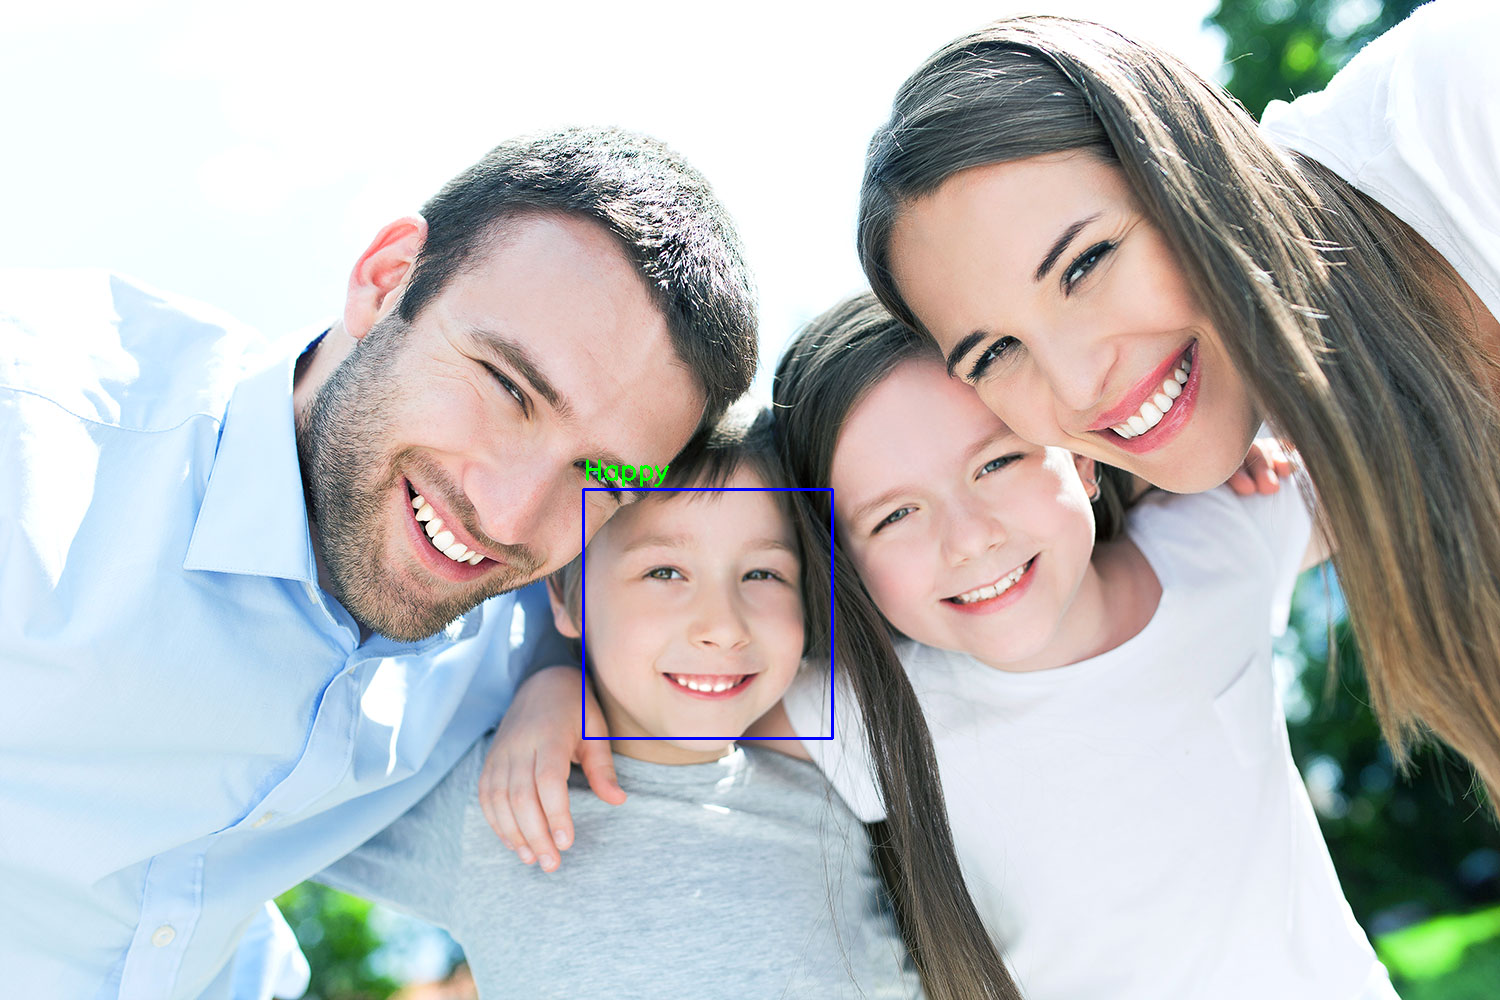

Facial Emotion Detected: Happy


In [ ]:
# ✅ Install dependencies
!pip install -q keras opencv-python librosa moviepy openai-whisper pydub ffmpeg-python

# ✅ Download pre-trained face emotion model
!wget -q https://github.com/oarriaga/face_classification/raw/master/trained_models/emotion_models/fer2013_mini_XCEPTION.102-0.66.hdf5 -O emotion_model.h5

# ✅ Imports
import cv2
import numpy as np
from keras.models import load_model
from google.colab import files
from google.colab.patches import cv2_imshow
import whisper
import librosa
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from pydub import AudioSegment
import os

# ✅ Load models
face_emotion_model = load_model("emotion_model.h5", compile=False)
face_emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
voice_model = whisper.load_model("base")

# ✅ Train dummy voice emotion classifier
def train_emotion_classifier():
    X = np.random.rand(100, 26)
    y = np.random.choice(['happy', 'sad', 'angry', 'neutral'], size=100)
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    clf = SVC(kernel='linear')
    clf.fit(X, y_encoded)
    return clf, le

emotion_classifier, label_encoder = train_emotion_classifier()

# ✅ Feature extraction from audio
def extract_audio_features(audio_path):
    y, sr = librosa.load(audio_path, sr=16000)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    pitch, _ = librosa.core.piptrack(y=y, sr=sr)
    pitch = np.mean(pitch, axis=1)
    mfcc_features = np.mean(mfcc, axis=1)
    pitch_features = pitch[:13]
    audio_features = np.concatenate([mfcc_features, pitch_features])
    return audio_features

# ✅ Voice emotion detection
def classify_emotion(features, classifier, le):
    idx = classifier.predict([features])[0]
    return le.inverse_transform([idx])[0]

def transcribe_audio(audio_path):
    result = voice_model.transcribe(audio_path)
    return result["text"], result["language"]

# ✅ Universal audio converter using pydub
def convert_audio_to_wav(input_path, output_path="/content/converted_audio.wav"):
    try:
        audio = AudioSegment.from_file(input_path)
        audio.export(output_path, format="wav")
        return output_path
    except Exception as e:
        raise RuntimeError(f"Conversion failed: {e}")

def emotion_aware_speech_recognition(audio_path):
    wav_path = convert_audio_to_wav(audio_path)
    transcription, language = transcribe_audio(wav_path)
    features = extract_audio_features(wav_path)
    emotion = classify_emotion(features, emotion_classifier, label_encoder)
    return emotion, transcription, language

# ✅ Face emotion detection
def detect_facial_emotion(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    detected_emotion = "No face found"
    for (x, y, w, h) in faces:
        roi = gray[y:y+h, x:x+w]
        roi = cv2.resize(roi, (64, 64))
        roi = roi.astype("float32") / 255.0
        roi = np.expand_dims(roi, axis=-1)
        roi = np.expand_dims(roi, axis=0)
        preds = face_emotion_model.predict(roi, verbose=0)
        detected_emotion = face_emotion_labels[np.argmax(preds)]
        cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)
        cv2.putText(img, detected_emotion, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    cv2_imshow(img)
    return detected_emotion

# ✅ Upload files (image or audio)
print("Upload an image (.jpg/.png) or any audio file (.mp4/.opus/.mp3/.wav)...")
uploaded = files.upload()

image_file = None
audio_file = None

for fname in uploaded:
    ext = fname.lower().split('.')[-1]
    if ext in ["png", "jpg", "jpeg"]:
        image_file = fname
    elif ext in ["mp3", "mp4", "opus", "m4a", "wav"]:
        audio_file = fname

# ✅ Decide which tasks to run
if image_file:
    print("\n🎭 Detecting Facial Emotion...")
    face_emotion = detect_facial_emotion(image_file)
    print("Facial Emotion Detected:", face_emotion)

if audio_file:
    print("\n🎤 Detecting Voice Emotion...")
    try:
        voice_emotion, transcription, language = emotion_aware_speech_recognition(audio_file)
        print("Voice Emotion Detected:", voice_emotion)
        print("Speech Transcription:", transcription)
        print("Language Detected:", language)
    except Exception as e:
        print("❌ Audio emotion detection failed:", str(e))

if not image_file and not audio_file:
    print("❗ Please upload at least one valid file (image or audio).")
